## Import

In [1]:
! pip install imblearn

In [2]:
! pip install tensorflow

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, roc_curve, roc_auc_score, recall_score,f1_score

import tensorflow as tf
from keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE
import seaborn as sns

2021-08-26 13:17:41.723472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-26 13:17:41.723519: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data preprocess & Integrity checking

In [2]:
df = pd.read_csv('all_yrs_processed.csv')
# Relabel the data:
# 0 -> termination & liqudiation
# 1 -> termination only
# 2 -> liqudation
# 3 -> normal
df.loc[(df['y_term']==1) & (df['y_liq']==1),'target'] = 0
df.loc[(df['y_term']==1) & (df['y_liq']==0),'target'] = 1
df.loc[(df['y_term']==0) & (df['y_liq']==1),'target'] = 2
df.loc[(df['y_term']==0) & (df['y_liq']==0),'target'] = 3
# drop orginal label 
col = ['y_term','y_liq','y_TL']
df.drop(columns=col,inplace=True)

df.head()

,ein,unrelbusinccd,initiationfees,grsrcptspublicuse,grsincmembers,grsincother,totcntrbgfts,totprgmrevnue,invstmntinc,txexmptbndsproceeds,...,nonpfreayr-1_6,nonpfreayr-1_7,nonpfreayr-1_8,nonpfreayr-1_9,nonpfreayr-1_11,nonpfreayr-1_12,nonpfreayr-1_13,nonpfreayr-1_14,nonpfreayr-1_15,target
0,910454080,0,0,0,0,0,935508,120315,7456,19969,...,0,0,0,0,0,0,0,0,0,3.0
1,111966978,0,0,0,0,0,0,5050020,153784,0,...,0,0,0,0,0,0,0,0,0,3.0
2,420660491,0,0,0,0,0,2945,11440,489,0,...,0,0,0,0,0,0,0,0,0,3.0
3,530152390,1,220425,468101,0,0,411058,2668044,29316,0,...,0,0,0,0,0,0,0,0,0,3.0
4,561547207,0,0,0,0,0,75,735052,783,0,...,0,0,0,0,0,0,0,0,0,3.0


In [3]:
# It is an unbalanced dataset
df.target.value_counts()

3.0    262779
2.0      2217
1.0      1232
0.0       159
Name: target, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266387 entries, 0 to 266386
Columns: 543 entries, ein to target
dtypes: float64(219), int64(324)
memory usage: 1.1 GB


In [5]:
df.shape

(266387, 543)

In [6]:
# At first glance, the data is recorded at different scale, 
# so normalization would be necessary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ein,266387.0,4.576145e+08,2.632679e+08,10018922.0,237249096.0,410951379.0,636005554.5,9.960869e+08
unrelbusinccd,266387.0,1.042844e-01,3.056297e-01,0.0,0.0,0.0,0.0,1.000000e+00
initiationfees,266387.0,3.665848e+03,9.193288e+04,-6975.0,0.0,0.0,0.0,1.744288e+07
grsrcptspublicuse,266387.0,3.186620e+03,6.970756e+04,-2592.0,0.0,0.0,0.0,1.427130e+07
grsincmembers,266387.0,2.158111e+05,7.335869e+06,0.0,0.0,0.0,0.0,1.197840e+09
...,...,...,...,...,...,...,...,...
nonpfreayr-1_12,266387.0,2.842106e-02,1.661728e-01,0.0,0.0,0.0,0.0,1.000000e+00
nonpfreayr-1_13,266387.0,9.486199e-03,9.693424e-02,0.0,0.0,0.0,0.0,1.000000e+00
nonpfreayr-1_14,266387.0,9.366073e-03,9.632437e-02,0.0,0.0,0.0,0.0,1.000000e+00
nonpfreayr-1_15,266387.0,9.035726e-03,9.462619e-02,0.0,0.0,0.0,0.0,1.000000e+00


### Missing value handling

In [7]:
nan = pd.DataFrame({'num_nan':df.isna().sum()})
nan.head()

,num_nan
ein,0
unrelbusinccd,0
initiationfees,0
grsrcptspublicuse,0
grsincmembers,0


In [8]:
nan[nan['num_nan']!=0]['num_nan'].unique()

array([    5, 38196])

In [9]:
nan[nan['num_nan']==5]

,num_nan
totsupp509,5
totsupp509yr-1,5


In [10]:
nan[nan['num_nan']==38196]

,num_nan
f1096cntyr-1,38196
fw2gcntyr-1,38196
noemplyeesw3cntyr-1,38196
f8282cntyr-1,38196
txexmptintyr-1,38196
...,...
samepubsuppsubtot509yr-1,38196
grsinc509yr-1,38196
unreltxincls511tx509yr-1,38196
netincunrelatd509yr-1,38196


In [11]:
# There are 108 columns which contains missing value,
# for the purpose of this project, all missing values will be dropped.
df = df.dropna()

In [12]:
# Around 14% of the data has been dropped in this step.
df.shape

(228181, 543)

In [13]:
df.target.value_counts()

3.0    225000
2.0      1975
1.0      1076
0.0       130
Name: target, dtype: int64

### Remove columns whoes value is only 0

In [16]:
def col_all_0(data):
    col = []
    for column in list(data.columns):
        if (data[column].nunique() == 1) and (data[column].unique()[0] == 0):
            col.append(column)
    return col

In [17]:
# check whether there are some columns in which all the records are 0
col_0 = col_all_0(df)
col_0

['filedlieuf1041cd']

In [18]:
# Personally, if the only value a column has is 0, the column would add little predictive power to the model
# so I would drop this column.
df.drop(columns=col_0,inplace=True)

In [19]:
df.shape

(228181, 542)

### Prepare dataset for SML

In [21]:
# ein column is considered as index, so will be excluded from feature
features = df.iloc[:,1:-1]
targets = df.iloc[:,-1:]

#### Normalization

In [24]:
# normalize
scaler = StandardScaler()
feature_nor = pd.DataFrame(data=scaler.fit_transform(features),columns=features.columns)
feature_nor.head()

,unrelbusinccd,initiationfees,grsrcptspublicuse,grsincmembers,grsincother,totcntrbgfts,totprgmrevnue,invstmntinc,txexmptbndsproceeds,royaltsinc,...,nonpfreayr-1_5,nonpfreayr-1_6,nonpfreayr-1_7,nonpfreayr-1_8,nonpfreayr-1_9,nonpfreayr-1_11,nonpfreayr-1_12,nonpfreayr-1_13,nonpfreayr-1_14,nonpfreayr-1_15
0,-0.343053,-0.040263,-0.045376,-0.030673,-0.018833,-0.066678,-0.012946,-0.004817,-0.011999,-0.010719,...,-0.035979,-0.070201,-0.698011,-0.069727,-0.607637,-0.031695,-0.175553,-0.099435,-0.096308,-0.094696
1,2.915005,-0.040263,-0.045376,-0.030673,-0.018833,0.019258,-0.005758,-0.025635,-0.011999,0.011511,...,-0.035979,-0.070201,-0.698011,-0.069727,-0.607637,-0.031695,-0.175553,-0.099435,-0.096308,-0.094696
2,-0.343053,-0.040263,-0.045376,-0.030673,-0.018833,-0.066678,-0.050722,-0.030766,-0.011999,-0.010719,...,-0.035979,-0.070201,-0.698011,-0.069727,-0.607637,-0.031695,-0.175553,-0.099435,-0.096308,-0.094696
3,2.915005,11.742606,2.960947,-0.030673,-0.018833,-0.066678,-0.029004,-0.027584,-0.011999,-0.010719,...,-0.035979,-0.070201,-0.698011,-0.069727,-0.607637,-0.031695,-0.175553,-0.099435,-0.096308,-0.094696
4,2.915005,-0.040263,-0.045376,-0.030673,-0.018833,0.305289,0.002305,-0.030081,-0.011999,-0.010719,...,-0.035979,-0.070201,-0.698011,-0.069727,-0.607637,-0.031695,-0.175553,-0.099435,-0.096308,-0.094696


In [25]:
feature_nor.describe()

,unrelbusinccd,initiationfees,grsrcptspublicuse,grsincmembers,grsincother,totcntrbgfts,totprgmrevnue,invstmntinc,txexmptbndsproceeds,royaltsinc,...,nonpfreayr-1_5,nonpfreayr-1_6,nonpfreayr-1_7,nonpfreayr-1_8,nonpfreayr-1_9,nonpfreayr-1_11,nonpfreayr-1_12,nonpfreayr-1_13,nonpfreayr-1_14,nonpfreayr-1_15
count,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,...,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05,2.281810e+05
mean,-1.181406e-13,1.100944e-13,4.417571e-14,-3.897120e-14,1.630375e-14,1.759710e-14,5.287503e-14,9.536040e-15,-2.641266e-15,1.362493e-14,...,-1.273219e-14,3.282958e-14,3.479959e-14,1.721203e-14,-1.441368e-13,-1.543130e-14,-4.755064e-14,1.757251e-14,-3.273080e-14,-2.155881e-14
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.430526e-01,-1.132167e-01,-8.100554e-02,-3.067252e-02,-5.522873e+01,-7.616185e-02,-1.037017e+00,-1.393910e+01,-9.522101e+00,-2.557068e-02,...,-3.597926e-02,-7.020092e-02,-6.980106e-01,-6.972652e-02,-6.076372e-01,-3.169539e-02,-1.755526e-01,-9.943477e-02,-9.630843e-02,-9.469625e-02
25%,-3.430526e-01,-4.026287e-02,-4.537587e-02,-3.067252e-02,-1.883253e-02,-6.661441e-02,-5.343491e-02,-3.077916e-02,-1.199880e-02,-1.071930e-02,...,-3.597926e-02,-7.020092e-02,-6.980106e-01,-6.972652e-02,-6.076372e-01,-3.169539e-02,-1.755526e-01,-9.943477e-02,-9.630843e-02,-9.469625e-02
50%,-3.430526e-01,-4.026287e-02,-4.537587e-02,-3.067252e-02,-1.883253e-02,-6.234677e-02,-5.279288e-02,-3.071889e-02,-1.199880e-02,-1.071930e-02,...,-3.597926e-02,-7.020092e-02,-6.980106e-01,-6.972652e-02,-6.076372e-01,-3.169539e-02,-1.755526e-01,-9.943477e-02,-9.630843e-02,-9.469625e-02
75%,-3.430526e-01,-4.026287e-02,-4.537587e-02,-3.067252e-02,-1.883253e-02,-4.650899e-02,-4.892196e-02,-2.919881e-02,-1.199880e-02,-1.071930e-02,...,-3.597926e-02,-7.020092e-02,1.432643e+00,-6.972652e-02,1.645719e+00,-3.169539e-02,-1.755526e-01,-9.943477e-02,-9.630843e-02,-9.469625e-02
max,2.915005e+00,1.824005e+02,1.961281e+02,1.529358e+02,2.580917e+02,2.205049e+02,3.385887e+02,2.951042e+02,2.740020e+02,3.514783e+02,...,2.779379e+01,1.424483e+01,1.432643e+00,1.434175e+01,1.645719e+00,3.155033e+01,5.696298e+00,1.005684e+01,1.038331e+01,1.056008e+01


#### Get train/Valid set

In [33]:
# Since it is an unbalanced dataset, stratify would make the train/validation datasets
#be more representative of the original dataset
validation_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(feature_nor,targets,test_size=validation_size,random_state=0,stratify=targets)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((182544, 540), (45637, 540), (182544, 1), (45637, 1))

In [35]:
y_train.value_counts()

target
3.0       179999
2.0         1580
1.0          861
0.0          104
dtype: int64

In [36]:
y_test.value_counts()

target
3.0       45001
2.0         395
1.0         215
0.0          26
dtype: int64

#### Downsampling

In [37]:
# resample the training set only
oversample = SMOTE(sampling_strategy={0:800, 1:1000, 2:1800})
X_up, y_up = oversample.fit_resample(X_train, y_train)

# down sample 3 in train set only
undersample = RandomUnderSampler(sampling_strategy={3:2000})
X_train, y_train = undersample.fit_resample(X_up, y_up)

In [38]:
y_train.value_counts()

target
3.0       2000
2.0       1800
1.0       1000
0.0        800
dtype: int64

## Classic ML models

In [39]:
y_test = y_test.values.ravel()
y_train = y_train.values.ravel()

In [40]:
def train(alglist,X_train,X_test,y_train, y_test):
    algorithms = pd.DataFrame()
    idx = 0

    for a in alglist:
        a.fit(X_train, y_train)
        pred_prob = a.predict_proba(X_test)
        pred1_prob = a.predict_proba(X_train)
        pred = a.predict(X_test)
        pred1 = a.predict(X_train)
        acc = accuracy_score(y_test, pred)
        f1 = f1_score(y_test, pred, average='micro')
        auc_train = roc_auc_score(y_train, pred1_prob, multi_class='ovo', average='macro')
        auc_test = roc_auc_score(y_test, pred_prob, multi_class='ovo', average='macro')
        rec =recall_score(y_test, pred, average='micro')
        
        Alg = a.__class__.__name__
        
        algorithms.loc[idx, 'Algorithm'] = Alg
        algorithms.loc[idx, 'Accuracy'] = acc
        algorithms.loc[idx, 'F1 Score'] = f1
        algorithms.loc[idx, 'AUC_test'] = auc_test
        algorithms.loc[idx, 'AUC_train'] = auc_train
        algorithms.loc[idx,'Recall'] = rec

        idx+=1
    return algorithms

In [42]:
alg = [RandomForestClassifier(),LogisticRegression()]

In [43]:
ml = train(alg,X_train,X_test,y_train, y_test)
ml

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Algorithm,Accuracy,F1 Score,AUC_test,AUC_train,Recall
0,RandomForestClassifier,0.730153,0.730153,0.691501,1.000000,0.730153
1,LogisticRegression,0.607336,0.607336,0.651366,0.841259,0.607336


## NN

In [45]:
# fully connected nn

def build_model(learning_rate):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=100, activation="relu", input_dim=540))  
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='categorical_crossentropy',
                metrics=[tf.keras.metrics.AUC(name='auc'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.AUC(name='prc', curve='PR')])

    return model


def train_model(model, feature, label, val_feature, val_label, epochs, batch_size):
    es = EarlyStopping(monitor='val_prc', 
                                   mode='max', 
                                   patience=10,
                                   restore_best_weights=True)
    history = model.fit(x=feature,
                      y=label,
                      validation_data=(val_feature, val_label),
                      callbacks=[es],
                      batch_size=batch_size,
                      epochs=epochs)
    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]

    epochs = history.epoch
    hist = pd.DataFrame(history.history)
#     accuracy = hist["accuracy"]
#     val_accuracy = hist['val_accuracy']
    return trained_weight, trained_bias, epochs, hist

In [46]:
from keras.utils import np_utils
learning_rate=0.001
epochs=500
my_batch_size=3000
NN_base = build_model(learning_rate)
dummy_y = np_utils.to_categorical(y_train)
dummy_y_test = np_utils.to_categorical(y_test)
trained_weight, trained_bias, epochs, hist = train_model(NN_base, X_train, dummy_y, X_test, dummy_y_test, epochs, my_batch_size)

Epoch 1/500
2/2 [==============================] - 3s 828ms/step - loss: 1.8082 - auc: 0.5055 - precision: 0.2596 - recall: 0.1018 - prc: 0.2565 - val_loss: 1.7651 - val_auc: 0.4161 - val_precision: 0.0763 - val_recall: 0.0133 - val_prc: 0.2002
Epoch 2/500
2/2 [==============================] - 0s 97ms/step - loss: 1.7222 - auc: 0.5474 - precision: 0.3268 - recall: 0.1187 - prc: 0.2902 - val_loss: 1.6704 - val_auc: 0.5067 - val_precision: 0.1072 - val_recall: 0.0192 - val_prc: 0.2359
Epoch 3/500
2/2 [==============================] - 0s 93ms/step - loss: 1.6095 - auc: 0.5877 - precision: 0.3961 - recall: 0.1436 - prc: 0.3279 - val_loss: 1.5663 - val_auc: 0.5963 - val_precision: 0.1663 - val_recall: 0.0315 - val_prc: 0.2899
Epoch 4/500
2/2 [==============================] - 0s 93ms/step - loss: 1.5475 - auc: 0.6107 - precision: 0.4171 - recall: 0.1514 - prc: 0.3458 - val_loss: 1.4618 - val_auc: 0.6721 - val_precision: 0.2557 - val_recall: 0.0524 - val_prc: 0.3547
Epoch 5/500
2/2 [======

In [47]:
NN_base.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               54100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
Total params: 54,504
Trainable params: 54,504
Non-trainable params: 0
_________________________________________________________________


In [48]:
def plot_the_model(label, prediction):
    plt.xlabel("label")
    plt.ylabel("prediction")
    plt.scatter(label, prediction)
    x0 = 0
    x1 = np.minimum(label.max(),prediction.max())
    plt.show()

In [49]:
def plot_the_loss(epochs, loss, val_loss):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.legend()

    plt.show()

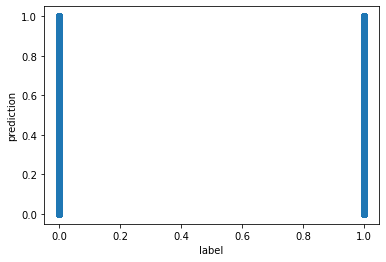

In [50]:
plot_the_model(dummy_y_test, NN_base.predict(X_test))

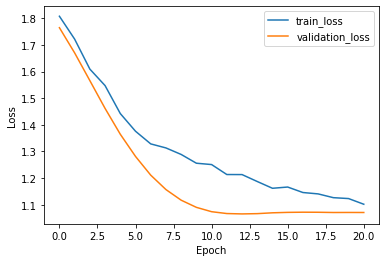

In [51]:
plot_the_loss(epochs, hist['loss'], hist['val_loss'])

In [52]:
NN_base.evaluate(X_test, dummy_y_test)

1427/1427 [==============================] - 2s 1ms/step - loss: 1.0736 - auc: 0.8520 - precision: 0.6981 - recall: 0.2859 - prc: 0.6098


[1.0736271142959595,
 0.8520203232765198,
 0.6981485486030579,
 0.2858864665031433,
 0.6098001003265381]

In [54]:
def plot_cm(labels, predictions):
    cm = confusion_matrix(labels,predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [55]:
y_pred=NN_base.predict(X_test)
classes_x = np.argmax(y_pred,axis=1)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=classes_x).numpy()

In [56]:
con_mat

array([[    1,     2,    10,    13],
       [   10,    28,    65,   112],
       [   11,    24,   211,   149],
       [ 2064,  2485, 10432, 30020]], dtype=int32)

Legitimate Transactions Detected (True Negatives):  1
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  28
Total Fraudulent Transactions:  215


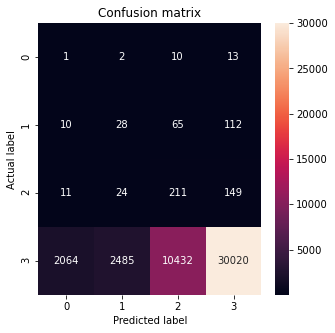

In [57]:
plot_cm(y_test,classes_x)

## 